# Table of contents

1. [**Preprocess the data**](#1)\
    1.1. [Load the data and tokenize the paper contents](#1.1)\
    1.2. [Remove Stopwords, Make Bigrams and Lemmatize](#1.2)\
    1.3. [Create the Dictionary and Corpus needed for Topic Modeling](#1.3)  
  
  
2. [**LDA Mallet Model**](#2)\
    2.1. [Grid Search to Find Optimal Topic Number for LDA Mallet Model](#2.1)\
    2.2. [LDA Model Exploration](#2.2)\
    2.3. [LDA model exploitation](#2.3)\
    2.3.1.  [Finding the dominant topic in each paper](#2.3.1)\
    2.3.2.  [Find the most representative document for each topic](#2.3.2)\
    2.3.3.  [Using TSNE to visulize topic](#2.3.3)  
 
 
3. [**The Author-Topic Model**](#3)\
    3.1. [construct the Author-Topic Model](#3.1)\
    3.2. [Author-Topic Model exploitation](#3.2)\
    3.2.1.  [Dimensionality Reduction using t-SNE to plot authors](#3.2.1)\
    3.2.2.  [Who has the same taste with me?](#3.2.2)\
    3.2.3.  [Topic network according to Author-Topic Network](#3.2.3)  
  
  
4. [**Coauthorship Network Exploration and Exploitation**](#4)\
    4.1. [Preprocess the data: merge the paper, paper_authors and author tables](#4.1)\
    4.2. [Construct the co-author network](#4.2)\
    4.3. [Explore the co-author network](#4.3)


In [3]:
# Run in python console
import ipywidgets as widgets
from IPython.display import display, HTML

import nltk; nltk.download('stopwords')

import re
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Other setting
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhechensu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Preprocess the data<a name="1"></a>

## 1.1 Load the data and tokenize the paper contents<a name="1.1"></a>
We get a list `contents` as output which has textual data of each pdf. Then tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether, '\n' for example. Gensim’s simple_preprocess() is great and fast for this. Additionally, set deacc=True to remove the punctuations.

The output is stored in `data_words` as a list of words

In [5]:
authors = pd.read_csv("/Users/zhechensu/Downloads/nips_dataset/authors.csv")
paper_authors = pd.read_csv("/Users/zhechensu/Downloads/nips_dataset/paper_authors.csv")
papers = pd.read_csv("/Users/zhechensu/Downloads/nips_dataset/papers.csv")

In [37]:
contents = list(papers.paper_text)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(contents))

## 1.2 Remove Stopwords, Make Bigrams and Lemmatize<a name="1.2"></a>

1. We download the stopwords dictionary from nltk and we add some specific word like 'et_al' that we want to filter.

2. Bigrams are two words frequently occurring together in the document. Some examples in our context are: ‘problem_solving’, ‘visual_representation' etc. 

3. By doing lemmatization, we just keep some particular word attribute like noun, adj, vb, adv, then change them to their root epression. eg: children->child

`min_count` and `threshold` are two important parameters for bigram. The higher the values of these parameters are, the harder it is for words to be combined to bigrams.

>`min_count`: int, ignore all words and bigrams having total appearance count lower than this. 

>`threshold`: int,  represents a score threshold for forming the phrases (higher means fewer phrases). 

In [38]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'gmail', 'isls', 'edu', 'use', 'et_al', 'fig', 'arxiv'])

min_count = 5
threshold = 30
#Set Bigram parameter
print("Bigram min_count:", min_count)
print("Bigram threshold:", threshold)

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=min_count, threshold=threshold) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Define functions for stopwords, bigrams, trigrams and lemmatization
import spacy

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


# Do lemmatization keeping only noun, adj, vb, adv
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

Bigram min_count: 5
Bigram threshold: 30


## 1.3 Create the Dictionary and Corpus needed for Topic Modeling<a name="1.3"></a>
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them!

We add a filter to the dictionary to get rid of words are too common and too rare.

>`no_below` : int;

>`no_above` : float; 

We keep tokens which are contained in above `no_below` and below `no_above` documents (fraction of total corpus size, not an absolute number).

In [39]:
#Set parameter
no_below = 30
no_above = 0.4
print("no_below(count):", no_below)
print("no_above(ratio):", no_above)

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

id2word.filter_extremes(no_below=no_below, no_above=no_above)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

no_below(count): 30
no_above(ratio): 0.4


**We try to use LDA Mallet Model and the Autor-Topic Model to do the topic network exploration and exploitation.**

# 2. LDA Mallet Model<a name="2"></a>
The MALLET topic modeling toolkit contains efficient, sampling-based implementations of Latent Dirichlet Allocation, Pachinko Allocation, and Hierarchical LDA. Mallet’s version often gives a better quality of topics. Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. 

In [27]:
mallet_path = './mallet/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics.value, id2word=id2word)

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5890192945527607


## 2.1 Grid Search to Find Optimal Topic Number for LDA Mallet Model<a name="2.1"></a>
The usual approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Generally, we choosing a number after the end of a rapid growth of topic coherence. The result usually offers meaningful and interpretable topics. However, the chosen topics may look like a combination of several TRUE topics. Picking an larger k can fix this problem.

>`start`: int, it is the start point of topic number of grid search;

>`limit`: int, it is the end point of topic number of grid search;

>`step`: int, it is the step size of topic number of grid search.

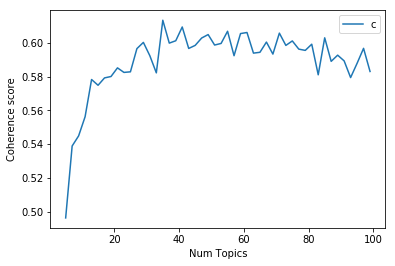

In [35]:
mallet_path = './mallet/bin/mallet' 
start = 5
limit = 100
step = 2

#Set parameter
print("start:", start)
print("limit:", limit)
print("step:", step)

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# # Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

# plt.show()
plt.savefig("./figure/grid_search.pdf", bbox_inches='tight')


Here we train the model for 5 times with 20 topics and choose the best one.

In [57]:
#Set parameter
topic_num = 20
print("topic_num:", topic_num)
model_list_LDA = []
for i in range(5):
    model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=topic_num.value, id2word=id2word)
    c = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    model_list_LDA.append((model, c.get_coherence()))
model, tc = max(model_list_LDA, key=lambda x: x[1])
# Save model.
model.save('./model/model_20.ldamodel')
# Load model.
model = gensim.models.wrappers.LdaMallet.load('./model/model_20.ldamodel')

## 2.2 LDA Model Exploration<a name="2.2"></a>

Let us print the keywords of each dominant topics.

In [121]:
# Select the model and print the topics
optimal_model = model#model_list[int((topic_num.value - start.value)/step.value)]
optimal_topic_num = topic_num.value
model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))

from collections import Counter
import matplotlib.colors as mcolors

topics = optimal_model.show_topics(num_topics=optimal_topic_num, formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

def concat(batch):
    return [w for w in batch.word]
df_topic_word = pd.DataFrame(df.groupby('topic_id').apply(concat))
df_topic_word.columns = ['words']
df_topic_word

words
topic_id                                                                                                                   
0         [label, classifier, margin, active, hypothesis, target, classifi, multi, boost, binary]                          
1         [gradient, convex, objective, stochastic, dual, min, smooth, minimization, norm, converge]                       
2         [posterior, bayesian, inference, likelihood, mixture, latent, variational, conditional, probabilistic, gp]       
3         [signal, filter, source, frequency, brain, channel, coefficient, correlation, speech, time_serie]                
4         [estimator, density, finite, entropy, bias, continuous, asymptotic, theoretical, converge, uniform]              
5         [policy, action, reward, agent, game, reinforcement_learn, player, environment, transition, strategy]            
6         [layer, deep, architecture, neural_network, convolutional, preprint, cnn, recurrent, gradient, rnn]              
7         [rule, neural_network, net, layer, hide, architecture, generalization, dynamic, activation, hidden_unit]         
8         [graph, node, tree, edge, vertex, inference, partition, path, product, degree]                                   
9         [sparse, column, rank, norm, sparsity, row, tensor, entry, recover, low_rank]                                    
10        [cluster, distance, metric, similarity, manifold, embed, clustering, projection, nearest_neighbor, eigenvector]  
11        [object, pixel, segmentation, recognition, face, detection, visual, scene, region, shape]                        
12        [bind, regret, lemma, online, lower_bound, round, arm, upper_bound, bandit, strategy]                            
13        [kernel, regression, svm, regularization, selection, operator, nonlinear, support_vector, polynomial, functional]
14        [human, response, trial, target, subject, stimulus, visual, behavior, cue, account]                              
15        [user, rank, item, group, query, score, event, individual, link, preference]                                     
16        [word, topic, document, language, text, sentence, lda, length, character, semantic]                              
17        [motion, position, location, region, trajectory, direction, field, move, surface, center]                        
18        [neuron, cell, spike, activity, response, stimulus, circuit, synaptic, dynamic, population]                      
19        [memory, search, bit, distribute, code, parallel, block, communication, scheme, store]

We will give the labels manually.

In [258]:
manul_label = pd.DataFrame([(0, 'Supervised Learning'),(1, 'Optimization'),(2, 'Gaussian Processes'),(3, 'Signal Processing'),(4, 'Information Theory'),
              (5, 'Reinforcement learning'),(6, 'Deep Learning'),(7, 'Deep Learning'),(8, 'Graph theory'),(9, 'Matrix and Tensor Factorization'),
              (10, 'Unsupervised Learning'),(11, 'Computer vision'),(12, 'Bandit algorithms'),(13, 'Kernel methods'),(14, 'Human Learning'),
              (15, 'Collaborative filtering'),(16, 'Information Retrieval'),(17, 'Naviguation and Planning'),(18, 'Neuroscience'),(19, 'Distributed Computing'),])
# manul_label = pd.DataFrame(l)
manul_label.columns = ['topic_num', 'topic_label']
df_topic_label.topic_label = manul_label.topic_label
df_topic_label

topic_label
0               Supervised Learning
1                      Optimization
2                Gaussian Processes
3                 Signal Processing
4                Information Theory
5            Reinforcement learning
6                     Deep Learning
7                     Deep Learning
8                      Graph theory
9   Matrix and Tensor Factorization
10            Unsupervised Learning
11                  Computer vision
12                Bandit algorithms
13                   Kernel methods
14                   Human Learning
15          Collaborative filtering
16            Information Retrieval
17         Naviguation and Planning
18                     Neuroscience
19            Distributed Computing

### 2.3 LDA model exploitation<a name="2.3"></a>

### 2.3.1 Finding the dominant topic in each paper<a name="2.3.1"></a>

One of the common application using topic modeling is to determine what topic a given document is about. Based on the word vector of a document, we will take the first, the word appearing the most frequently in the document. Also, we will add each document's dominant topic contribution (proportion) and label to the dataframe. In the last part, the label of the paper will be used for clustering.

In [123]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=contents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
#         print(i)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# optimal_model = gensim.models.wrappers.LdaMallet('./mallet/bin/mallet', corpus=corpus, num_topics=20, id2word=id2word)
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=contents)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic = df_dominant_topic.merge(df_topic_label, left_on='Dominant_Topic', right_index=True).sort_values(by = 'Document_No')
# Show
pd.set_option('display.max_colwidth', 50)
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0            17.0              0.2214   
1            1            18.0              0.6000   
2            2            18.0              0.7934   
3            3             7.0              0.2541   
4            4             0.0              0.5253   
5            5             7.0              0.3268   
6            6             7.0              0.2941   
7            7            18.0              0.2784   
8            8            17.0              0.2566   
9            9            18.0              0.3361   

                                            Keywords  \
0  motion, position, location, region, trajectory...   
1  neuron, cell, spike, activity, response, stimu...   
2  neuron, cell, spike, activity, response, stimu...   
3  rule, neural_network, net, layer, hide, archit...   
4  label, classifier, margin, active, hypothesis,...   
5  rule, neural_network, net, layer, hide, archit...   
6  rule, neural_network, net, layer, hide, archit...   
7  neuron, cell, spike, activity, response, stimu...   
8  motion, position, location, region, trajectory...   
9  neuron, cell, spike, activity, response, stimu...   

                                                Text topic_label  
0  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...    lable_17  
1  683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...    lable_18  
2  394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...    lable_18  
3  Bayesian Query Construction for Neural\nNetwor...     lable_7  
4  Neural Network Ensembles, Cross\nValidation, a...     lable_0  
5  U sing a neural net to instantiate a\ndeformab...     lable_7  
6  Plasticity-Mediated Competitive Learning\n\nTe...     lable_7  
7  ICEG Morphology Classification using an\nAnalo...    lable_18  
8  Real-Time Control of a Tokamak Plasma\nUsing N...    lable_17  
9  Real-Time Control of a Tokamak Plasma\nUsing N...    lable_18

### Find the most representative document for each topic<a name="2.3.2"></a>

The cell above shows the contribution, and in this cell, we will sort the contribution for every topic. In this way, it shows what is the most representative document of a particular topic. And by looking through the document, we can find a good example of the topic and have a sense of the content.

In [260]:

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

sent_topics_sorteddf_mallet = sent_topics_sorteddf_mallet.merge(df_topic_label, left_index=True, right_index=True)

# Show
pd.set_option('display.max_colwidth', 50)
sent_topics_sorteddf_mallet

Topic_Num  Topic_Perc_Contrib  \
0         0.0              0.7015   
1         1.0              0.8163   
2         2.0              0.7159   
3         3.0              0.7491   
4         4.0              0.6501   
5         5.0              0.7930   
6         6.0              0.6980   
7         7.0              0.7008   
8         8.0              0.7784   
9         9.0              0.7697   
10       10.0              0.7137   
11       11.0              0.7905   
12       12.0              0.8005   
13       13.0              0.6434   
14       14.0              0.7537   
15       15.0              0.6977   
16       16.0              0.7702   
17       17.0              0.6118   
18       18.0              0.8314   
19       19.0              0.6094   

                                             Keywords  \
0   label, classifier, margin, active, hypothesis,...   
1   gradient, convex, objective, stochastic, dual,...   
2   posterior, bayesian, inference, likelihood, mi...   
3   signal, filter, source, frequency, brain, chan...   
4   estimator, density, finite, entropy, bias, con...   
5   policy, action, reward, agent, game, reinforce...   
6   layer, deep, architecture, neural_network, con...   
7   rule, neural_network, net, layer, hide, archit...   
8   graph, node, tree, edge, vertex, inference, pa...   
9   sparse, column, rank, norm, sparsity, row, ten...   
10  cluster, distance, metric, similarity, manifol...   
11  object, pixel, segmentation, recognition, face...   
12  bind, regret, lemma, online, lower_bound, roun...   
13  kernel, regression, svm, regularization, selec...   
14  human, response, trial, target, subject, stimu...   
15  user, rank, item, group, query, score, event, ...   
16  word, topic, document, language, text, sentenc...   
17  motion, position, location, region, trajectory...   
18  neuron, cell, spike, activity, response, stimu...   
19  memory, search, bit, distribute, code, paralle...   

                                                 Text  \
0   Co-regularization Based Semi-supervised Domain...   
1   Doubly Accelerated\nStochastic Variance Reduce...   
2   AIDE: An algorithm for measuring the accuracy ...   
3   Separation of Music Signals by Harmonic\nStruc...   
4   Multivariate f -Divergence Estimation With\nCo...   
5   Playing is believing:\nThe role of beliefs in ...   
6   Multimodal Residual Learning for Visual QA\n\n...   
7   An Integrated Architecture of Adaptive Neural ...   
8   Optimal sub-graphical models\n\nMukund Narasim...   
9   Robust Tensor Decomposition with Gross Corrupt...   
10  Sparse Manifold Clustering and Embedding\n\nRe...   
11  Unsupervised Template Learning for\nFine-Grain...   
12  Best Arm Identification: A Unified Approach to...   
13  From Regularization Operators\nto Support Vect...   
14  Active inference in concept learning\n\nJonath...   
15  Beyond Parity:\nFairness Objectives for Collab...   
16  Symmetric Correspondence Topic Models for\nMul...   
17  An Integrated Vision Sensor for the\nComputati...   
18  Recurrent Cortical Amplification Produces\nCom...   
19  ?Short-Dot?: Computing Large Linear Transforms...   

                        topic_label  
0               Supervised Learning  
1                      Optimization  
2                Gaussian Processes  
3                 Signal Processing  
4                Information Theory  
5            Reinforcement learning  
6                     Deep Learning  
7                     Deep Learning  
8                      Graph theory  
9   Matrix and Tensor Factorization  
10            Unsupervised Learning  
11                  Computer vision  
12                Bandit algorithms  
13                   Kernel methods  
14                   Human Learning  
15          Collaborative filtering  
16            Information Retrieval  
17         Naviguation and Planning  
18                     Neuroscience  
19            Distributed Computing

### Using TSNE to visulize topic<a name="2.3.3"></a>

Now we visualize the distribution of topics in a 2D graph. To do this, we reduce the dimensionality of this data using t-SNE. t-SNE is a method that attempts to reduce the dimensionality of a dataset, while maintaining the distances between the points. That means that if two topics are close together in the plot below, then their distributions of words are similar.

In [5]:
from sklearn.manifold import TSNE
model = gensim.models.wrappers.LdaMallet.load('model_20.ldamodel')

# Select the model and print the topics
optimal_model = model
hm = np.array([[y for (x,y) in optimal_model[corpus[i]]] for i in range(len(corpus))])
tsne = TSNE(random_state=2018, perplexity=30, early_exaggeration=120)
embedding = tsne.fit_transform(hm)
embedding = pd.DataFrame(embedding, columns=['x','y'])
embedding['hue'] = hm.argmax(axis=1)

In [14]:
# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
output_notebook()

df = papers
source = ColumnDataSource(
        data=dict(
            x = embedding.x,
            y = embedding.y,
            colors = [all_palettes['Category20b'][20][i] for i in embedding.hue],
            title = df.title,
            year = df.year,
            alpha = [0.9] * embedding.shape[0],
            size = [7] * embedding.shape[0]
        )
    )
hover_tsne = HoverTool(names=["df"], tooltips="""
    <div style="margin: 10">
        <div style="margin: 0 auto; width:300px;">
            <span style="font-size: 12px; font-weight: bold;">Title:</span>
            <span style="font-size: 12px">@title</span>
            <span style="font-size: 12px; font-weight: bold;">Year:</span>
            <span style="font-size: 12px">@year</span>
        </div>
    </div>
    """)
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(plot_width=700, plot_height=700, tools=tools_tsne, title='Papers')
plot_tsne.circle('x', 'y', size='size', fill_color='colors', 
                 alpha='alpha', line_alpha=0, line_width=0.01, source=source, name="df")

callback = CustomJS(args=dict(source=source), code=
    """
    var data = source.data;
    var f = cb_obj.value
    x = data['x']
    y = data['y']
    colors = data['colors']
    alpha = data['alpha']
    title = data['title']
    year = data['year']
    size = data['size']
    for (i = 0; i < x.length; i++) {
        if (year[i] <= f) {
            alpha[i] = 0.9
            size[i] = 7
        } else {
              alpha[i] = 0.05
            size[i] = 4
        }
    }
    source.change.emit();
    """)

slider = Slider(start=df.year.min(), end=df.year.max(), value=2016, step=1, title="Before year")
slider.js_on_change('value', callback)

layout = column(slider, plot_tsne)
show(layout)


Loading BokehJS ...

<img src="figure/Doc_TSNE.png" style="width: 500px;"/>

# 3 The Author-Topic Model<a name="3"></a>

## 3.1 Construct the Author-Topic Model<a name="3.1"></a>

The Author-Topic Model (ATM) is an extension of Latent Dirichlet Allocation (LDA) that allows us to learn the topic representation of the authors in a corpus. The model can be applied to any kinds of labels on documents, such as tags on posts on the web. The model can be used as a novel way of data exploration, for example as features in machine learning pipelines, for author (or tag) prediction, or to simply leverage the topic model with existing metadata.

In [45]:
docid_pd = papers.copy()
docid_pd['docid'] = papers.index
df_all = pd.merge(docid_pd, paper_authors, left_on='id', right_on='paper_id')
df_all = pd.merge(df_all, authors, left_on='author_id', right_on='id')
df = df_all[['docid', 'author_id', 'name']]

#Create author2doc
author2doc = dict()
t = df[['name', 'docid']].drop_duplicates()
for index, row in t.iterrows():
    author_name = row[0]
    if not author2doc.get(author_name):
        # This is a new author.
        author2doc[author_name] = []
    # Add document IDs to author.
    author2doc[author_name].extend([row[1]])

#Train
from gensim.models import AuthorTopicModel
model_list_ATM = []
for i in range(1): 
    model = AuthorTopicModel(corpus=corpus, num_topics=20, id2word=id2word, \
                    author2doc=author2doc, chunksize=2000, passes=100, gamma_threshold=1e-10, \
                    eval_every=0, iterations=1)#, random_state=i)
    top_topics = model.top_topics(corpus)
    tc = sum([t[1] for t in top_topics])
    model_list_ATM.append((model, tc))
    
model, tc = max(model_list_ATM, key=lambda x: x[1])
# Save model.
model.save('./model/model.atmodel')
Load model.
model = AuthorTopicModel.load('./model/model.atmodel')

print('Number of authors: %d' % len(author2doc))
print('Number of documents: %d' % len(corpus))
print('Topic coherence: %.3e' %tc)

Number of authors: 11630
Number of documents: 8250
Topic coherence: -9.580e+01


In [202]:
from pprint import pprint
def show_author(name):
    print('\n%s' % name)
    print('Docs:', model.author2doc[name])
    print('Topics:')
    pprint([(topic_labels[topic[0]], topic[1]) for topic in model[name]])
show_author(author_name.value)


Terrence J. Sejnowski
Docs: [2, 6, 23, 41, 47, 81, 98, 103, 113, 116, 129, 203, 234, 249, 321, 322, 349, 352, 376, 466, 563, 627, 647, 854, 856, 958, 994, 1385, 1638, 1766, 1939, 2092, 2203, 4110, 4542, 4564, 5103, 5835, 6400, 6677, 6982, 7026, 7048, 7117, 7121, 7165, 7192, 7234]
Topics:
[('neuron+cell+stimulus', 0.9999290468440801)]


In [203]:
#Set parameter
print("topic_name:")
topic_name = widgets.Text(value =df_topic_word_author.iloc[model[author_name.value][0][0]][0])
display(topic_name)

topic_name:


Text(value='neuron+cell+stimulus')

In [204]:
model.show_topic(df_topic_word_author[df_topic_word_author.topic_label == topic_name.value].index[0])

[('neuron', 0.032686433215181686),
 ('cell', 0.01576150783848299),
 ('stimulus', 0.01453930383014152),
 ('response', 0.014309397702681028),
 ('activity', 0.010636153228473172),
 ('spike', 0.01060448780512941),
 ('circuit', 0.006702316817707731),
 ('dynamic', 0.006512500070086313),
 ('signal', 0.005945248098041116),
 ('visual', 0.005443502478849936)]

## 3.2 Author-Topic Model exploitation<a name="3.2"></a>

### 3.2.1  Dimensionality Reduction using t-SNE to plot authors <a name="3.2.1"></a>
Now we are going to use TSNE to plot authors-topic relationships.

We take all the author-topic distributions (stored in model.state.gamma) and embed them in a 2D space. Similarly to the above graph, if two authors are close together in the plot below, then their distributions of topics are similar.

In the cell below, we transform the author-topic representation into the t-SNE space. We can increase the smallest_author value if we do not want to view all the authors with few documents.

In [46]:
# %%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
smallest_author = 2  # Ignore authors with documents less than this.
authors = [model.author2id[a] for a in model.author2id.keys() if len(model.author2doc[a]) >= smallest_author]
_ = tsne.fit_transform(model.state.gamma[authors, :])  # Result stored in tsne.embedding_

In [47]:
# Tell Bokeh to display plots inside the notebook.
from bokeh.io import output_notebook
output_notebook()
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, ColumnDataSource

x = tsne.embedding_[:, 0]
y = tsne.embedding_[:, 1]
author_names = [model.id2author[a] for a in authors]

# Radius of each point corresponds to the number of documents attributed to that author.
scale = 0.1
author_sizes = [len(model.author2doc[a]) for a in author_names]
radii = [size * scale for size in author_sizes]

source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            author_names=author_names,
            author_sizes=author_sizes,
            radii=radii,
        )
    )

# Add author names and sizes to mouse-over info.
hover = HoverTool(
        tooltips=[
        ("author", "@author_names"),
        ("size", "@author_sizes"),
        ]
    )

p = figure(tools=[hover, 'crosshair,pan,wheel_zoom,box_zoom,reset,save,lasso_select'])
p.scatter('x', 'y', radius='radii', source=source, fill_alpha=0.6, line_color=None)
show(p)

Loading BokehJS ...

<img src="figure/Author_TSNE.png" style="width: 500px;">

### 3.2.2 Who has the same taste with me? <a name="3.2.2"></a>
Most of the authors publish less than 1 paper per year. However, it would be difficult to find the topic preference of these authors with only 1 or 2 papers related to them, as we are reducing the preference problem to comparing document features. We will probably get large biases if we treat the textual content directly as their preference. Thus, we will discard these authors having published less than ```smallest_author``` papers.

The framework uses the cosine distance, but we want to use the Hellinger distance since we are calculating the distance for distributions. The Hellinger distance is a natural way of measuring the distance (i.e. dis-similarity) between two probability distributions. Its discrete version is defined as
$$
H(p, q) = \frac{1}{\sqrt{2}} \sqrt{\sum_{i=1}^K (\sqrt{p_i} - \sqrt{q_i})^2},
$$

where $p$ and $q$ are both topic distributions for two different authors. We define the similarity as
$$
S(p, q) = \frac{1}{1 + H(p, q)}.
$$

In the cell below, we prepare everything we need to perform similarity queries based on the Hellinger distance.

In [8]:
# Make a function that returns similarities based on the Hellinger distance.
from gensim import matutils

# Make a list of all the author-topic distributions.
author_vecs = [model.get_author_topics(author) for author in model.id2author.values()]

def similarity(vec1, vec2):
    '''Get similarity between two vectors'''
    dist = matutils.hellinger(matutils.sparse2full(vec1, model.num_topics), \
                              matutils.sparse2full(vec2, model.num_topics))
    sim = 1.0 / (1.0 + dist)
    return sim

def get_sims(vec):
    '''Get similarity of vector to all authors.'''
    sims = [similarity(vec, vec2) for vec2 in author_vecs]
    return sims

def get_table(name, top_n=10, smallest_author=2):
    '''
    Get table with similarities, author names, and author sizes.
    Return `top_n` authors as a dataframe.
    
    '''
    
    # Get similarities.
    sims = get_sims(model.get_author_topics(name))

    # Arrange author names, similarities, and author sizes in a list of tuples.
    table = []
    for elem in enumerate(sims):
        author_name = model.id2author[elem[0]]
        sim = elem[1]
        author_size = len(model.author2doc[author_name])
        if author_size >= smallest_author:
            table.append((author_name, sim, author_size))
            
    # Make dataframe and retrieve top authors.
    df = pd.DataFrame(table, columns=['Author', 'Score', 'Size'])
    df = df.sort_values('Score', ascending=False)[:top_n]
    topic = []
    for name in df.Author:
        topic.append(sorted(model[name], key=lambda x: (x[1]), reverse=True) )
    df['topic'] = topic
    return df

#collect author co authorship and make adjacent matix
def find_coauth(au):
    for i in range(len(au)-1):
        for j in range(i+1, len(au)):
            au1 = au['name'].values[i]
            au2 = au['name'].values[j]
            co_auth.at[au1,au2] += 1
            co_auth.at[au2,au1] += 1
co_auth = pd.DataFrame(np.zeros(shape=(len(author2doc),len(author2doc))))
co_auth.columns=df.name.unique()
co_auth.index=df.name.unique()
t = df.groupby(['docid']).apply(find_coauth)

In [9]:
author_name = 'Terrence J. Sejnowski'
pd.set_option('display.max_colwidth', 50)
get_table(author_name)

Author     Score  Size                       topic
2845  Terrence J. Sejnowski  1.000000    48  [(11, 0.9999290468440801)]
2258            Peter Dayan  0.999995    47  [(11, 0.9999435699752137)]
534           Christof Koch  0.999985    35  [(11, 0.9998864424808276)]
2680                  Si Wu  0.999912     9  [(11, 0.9996814870352174)]
66           Alan F. Murray  0.999907    11   [(11, 0.999664936787143)]
251        Anthony M. Zador  0.999897     8   [(11, 0.999638815817049)]
523    Christian K. Machens  0.999875     7  [(11, 0.9995754359247159)]
2469      Rodney J. Douglas  0.999872     8  [(11, 0.9995657793713213)]
509            Chris Diorio  0.999842     7  [(11, 0.9994811398151168)]
1620        Kevin A. Archie  0.999781     3  [(11, 0.9993097480936701)]

### 3.2.3  Topic network according to Author-Topic Network<a name="3.2.3"></a>

In this part we attempt to identify the relationships between topics. The question to ask is: Are certain topics likedly to co-occur? We will create a network where each node represents a topic. For each paper, we will create co-authorship pairs. For example, if A, B and C co-authored the same paper, we will generate the following pairs: A-B, A-C, B-C. Then, we will link two topic nodes D-E if author A mainly works on D (i.e. is in node D) and author B mainly works on E and A-B is in the co-authorship pairs we have built previously. We can observe some interesting clusters between topics. 


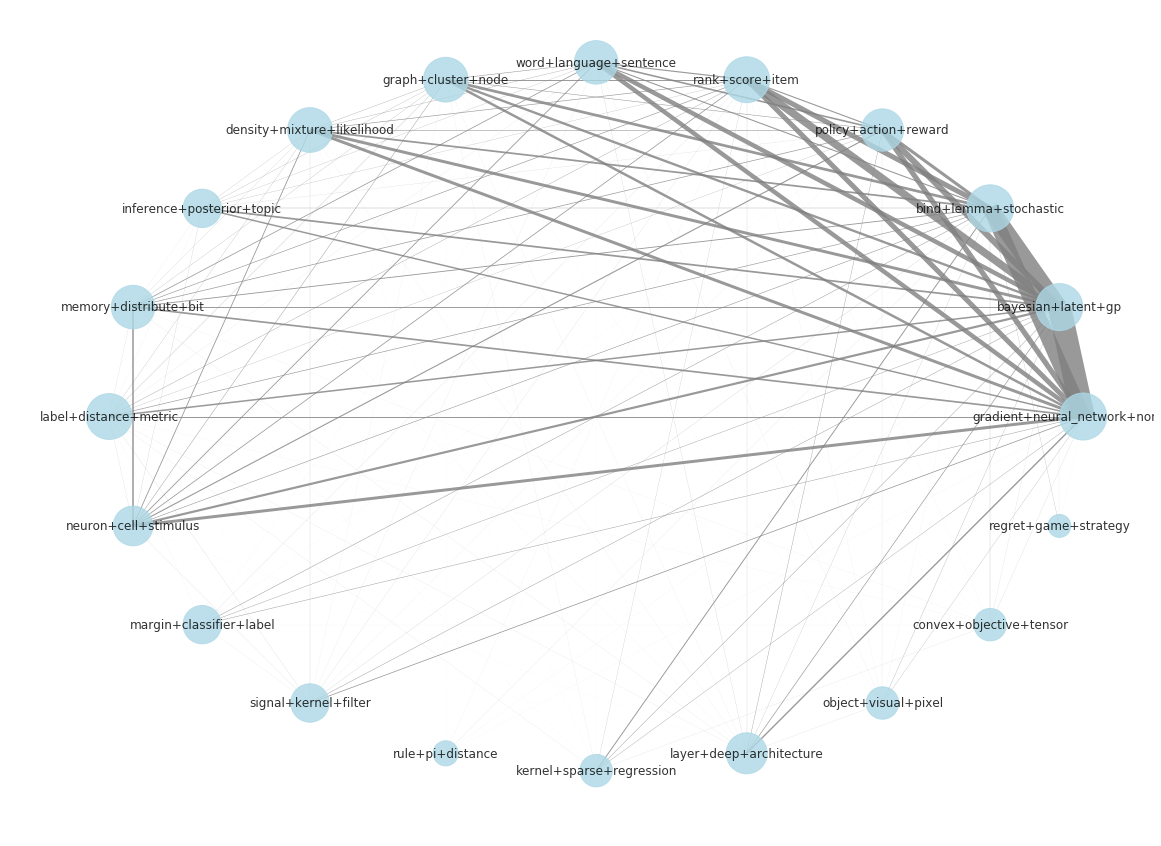

In [228]:
G = nx.graph
def cal_topicWeight(au):
    min_nu = 0
    for i in range(len(au)-1):
        for j in range(i+1, len(au)):
#             print(au['name'].values)
#             print('---')
            au1 = au['name'].values[i]
            au2 = au['name'].values[j]
            tpc1 = topic_labels[model[au1][0][0]]
            tpc2 = topic_labels[model[au2][0][0]]
            weight_topic.at[tpc1,tpc2] += 1
            weight_topic.at[tpc2,tpc1] += 1

weight_topic = pd.DataFrame(np.zeros(shape=(20, 20)))
weight_topic.columns=topic_labels
weight_topic.index=topic_labels

df.groupby(['docid']).apply(cal_topicWeight)
G = nx.from_pandas_adjacency(weight_topic)

node_size = (np.array(list(nx.degree_centrality(G).values())))*2000
edge_color= np.array(list(nx.get_edge_attributes(G, 'weight').values()))
palette = sns.color_palette(palette='Set1', n_colors=2)
from matplotlib.colors import ListedColormap
plt.figure(figsize=(20, 15), frameon=False)
pos = nx.layout.shell_layout(G, scale=0.5)

plt.axis('off')
nx.draw(G, pos=pos, edge_color='grey', width = edge_color/100, 
        edge_cmap = plt.cm.gray_r, alpha=0.8, 
        cmap=ListedColormap(palette.as_hex()), 
        node_size=node_size, 
        with_labels=True, 
        node_color='#add8e6')
                
# plt.savefig('figures/country_collab')
plt.show()

# 4. Coauthorship Network Exploration and Exploitation<a name="4"></a>

## 4.1 Preprocess the data: merge the paper, paper_authors and author tables<a name="4.1"></a>

In [15]:
df_all = pd.merge(papers, paper_authors, left_on='id', right_on='paper_id', suffixes=('_paper',''))
df_all.drop(columns=['id_paper', 'id'], inplace=True)
df_all = pd.merge(df_all, authors, left_on='author_id', right_on='id')
df_all.drop(columns=['id'], inplace=True)
df_all.head(3)

year                                              title event_type  \
0  1987  Self-Organization of Associative Database and ...        NaN   
1  1987  Self-Organization of Associative Database and ...        NaN   
2  1987  A Mean Field Theory of Layer IV of Visual Cort...        NaN   

                                            pdf_name          abstract  \
0  1-self-organization-of-associative-database-an...  Abstract Missing   
1  1-self-organization-of-associative-database-an...  Abstract Missing   
2  10-a-mean-field-theory-of-layer-iv-of-visual-c...  Abstract Missing   

                                          paper_text  paper_id  author_id  \
0  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...         1          1   
1  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...         1          2   
2  683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...        10         14   

                      name  
0           Hisashi Suzuki  
1           Suguru Arimoto  
2  Christopher L. Scofield

## 4.2 Construct the co-author network<a name="4.2"></a>

In [16]:
self_merge = pd.merge(df_all, df_all, on='paper_id', suffixes=('_left', '_right'))
self_merge = self_merge[self_merge.name_left != self_merge.name_right]
self_merge.head(1)

year_left                                         title_left  \
1       1987  Self-Organization of Associative Database and ...   

  event_type_left                                      pdf_name_left  \
1             NaN  1-self-organization-of-associative-database-an...   

      abstract_left                                    paper_text_left  \
1  Abstract Missing  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...   

   paper_id  author_id_left       name_left  year_right  \
1         1               1  Hisashi Suzuki        1987   

                                         title_right event_type_right  \
1  Self-Organization of Associative Database and ...              NaN   

                                      pdf_name_right    abstract_right  \
1  1-self-organization-of-associative-database-an...  Abstract Missing   

                                    paper_text_right  author_id_right  \
1  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...                2   

       name_right  
1  Suguru Arimoto

**Nodes represent the unique authors in the nips dataset between 1987 and 2018**

In [17]:
nodes = df_all[~df_all.name.duplicated()].reset_index(drop=True).reset_index()
print("The number of nodes in the co-author network is: ", len(nodes))
nodes.head(1)

The number of nodes in the co-author network is:  11630


index  year                                              title event_type  \
0      0  1987  Self-Organization of Associative Database and ...        NaN   

                                            pdf_name          abstract  \
0  1-self-organization-of-associative-database-an...  Abstract Missing   

                                          paper_text  paper_id  author_id  \
0  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...         1          1   

             name  
0  Hisashi Suzuki

**Numeric the author name in order to construct edges later**

In [18]:
name_index = nodes.name.to_dict()
name_index = {v: k for k, v in name_index.items()}
self_merge['source'] = self_merge.name_left.map(name_index)
self_merge['target'] = self_merge.name_right.map(name_index)
self_merge.head(1)

year_left                                         title_left  \
1       1987  Self-Organization of Associative Database and ...   

  event_type_left                                      pdf_name_left  \
1             NaN  1-self-organization-of-associative-database-an...   

      abstract_left                                    paper_text_left  \
1  Abstract Missing  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...   

   paper_id  author_id_left       name_left  year_right  \
1         1               1  Hisashi Suzuki        1987   

                                         title_right event_type_right  \
1  Self-Organization of Associative Database and ...              NaN   

                                      pdf_name_right    abstract_right  \
1  1-self-organization-of-associative-database-an...  Abstract Missing   

                                    paper_text_right  author_id_right  \
1  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...                2   

       name_right  source  target  
1  Suguru Arimoto       0       1

**generate the co-author network according to the adjacency matrix   
the weight of the edge is the number of the papers two author published together**

In [19]:
def get_adjacency(nodes, edges):
    n_nodes = len(nodes)
    adjacency = np.zeros((n_nodes, n_nodes), dtype=int)

    for idx, row in edges.iterrows():
        i, j = int(row.source), int(row.target)
        adjacency[i, j] += 1

    return adjacency

adjacency = get_adjacency(nodes, self_merge)
graph = nx.from_numpy_array(adjacency)

**Visualize the generated co-author network**

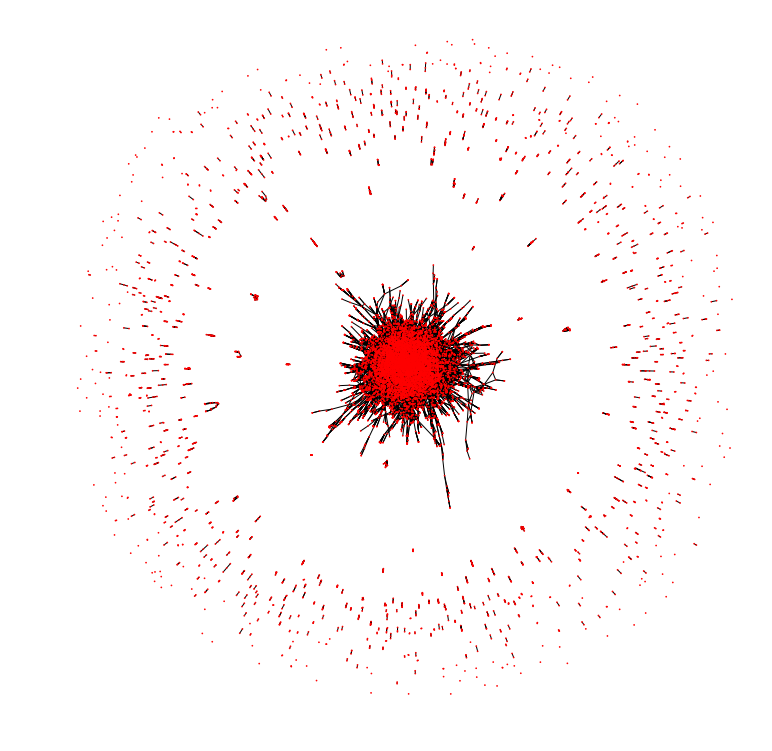

In [20]:
pos = nx.layout.fruchterman_reingold_layout(graph)
plt.figure(figsize=(10, 10))
nx.draw(graph, pos=pos, node_size=[0.5,0.5])

## 4.3 Explore the co-author network<a name="4.3"></a>

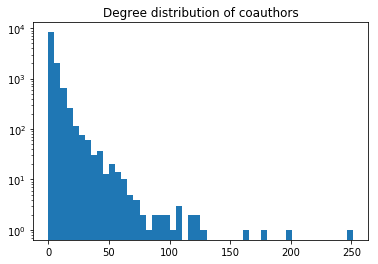

In [21]:
plt.title('Degree distribution of coauthors')
plt.hist(adjacency.sum(axis=1), bins=50, log=True)
plt.show()

**Observation**
1. We can observe that most nodes in the co-author network have small degrees
2. Only a few authors have large degrees
3. Most researchers have limited cooperation relationship between other researchers.

**Calculate the component sizes of the co-author network**

In [22]:
component = pd.Series([len(i) for i in list(nx.connected_components(graph))]).value_counts().sort_index()
component = pd.DataFrame(component).reset_index()
component.columns = ['component_size', 'number of components']
component

component_size  number of components
0                1                   211
1                2                   291
2                3                   192
3                4                    95
4                5                    44
5                6                    26
6                7                    24
7                8                     7
8                9                     5
9               10                     2
10              11                     4
11              12                     4
12              13                     2
13              14                     2
14              16                     1
15              17                     1
16              18                     1
17              20                     1
18              21                     1
19            8978                     1

**Observation**
We can observe that there is only one largest component contains 8978 authors, and many small communities.

In [23]:
largest_cc = max(nx.connected_components(graph), key=len)
print(f'the largest component contains : {len(largest_cc)} authors')
print("The total number of components is: ", nx.number_connected_components(graph))

the largest component contains : 8978 authors
The total number of components is:  915


**Explore the centrality of the largest component**  
Betweenness centrality is a measure of the influence of a vertex over the flow of information between every pair of vertices under the assumption that information primarily flows over the shortest paths between them. So here we use the betweenness_centrality to highlight nodes that function as "bridges" between people.

In [24]:
centrality = nx.betweenness_centrality(graph.subgraph(largest_cc))

**Summary statistics of the centrality**

In [25]:
pd.Series(np.array(list(centrality.values()))).describe()

count    8978.000000
mean        0.000552
std         0.002876
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000151
max         0.142048
dtype: float64

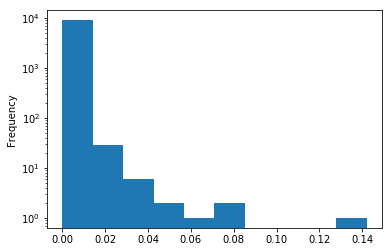

In [26]:
ax = pd.Series(np.array(list(centrality.values()))).plot.hist()
ax.set_yscale('log')

In [27]:
print("The lowest betweenness centrality of the top 0.25% nodes:", np.quantile(np.array(list(centrality.values())), 0.9975))

The lowest betweenness centrality of the top 0.25% nodes: 0.01905419168631666


**Observation**
1. The largest betweenness centrality of the co-author network is 0.142
2. Most nodes has the betweenness centrality value 0
3. We highlight the nodes with betweenness centrality of the top 0.25%

In [28]:
lables = nodes.name.to_dict()
lables = { key: lables[key] for (key, value) in centrality.items() if value > 0.01905419168631666}

In [29]:
# For visualize purpose, we enlarge the node size according to the centrality value
node_size = np.array(list(centrality.values()))*10000

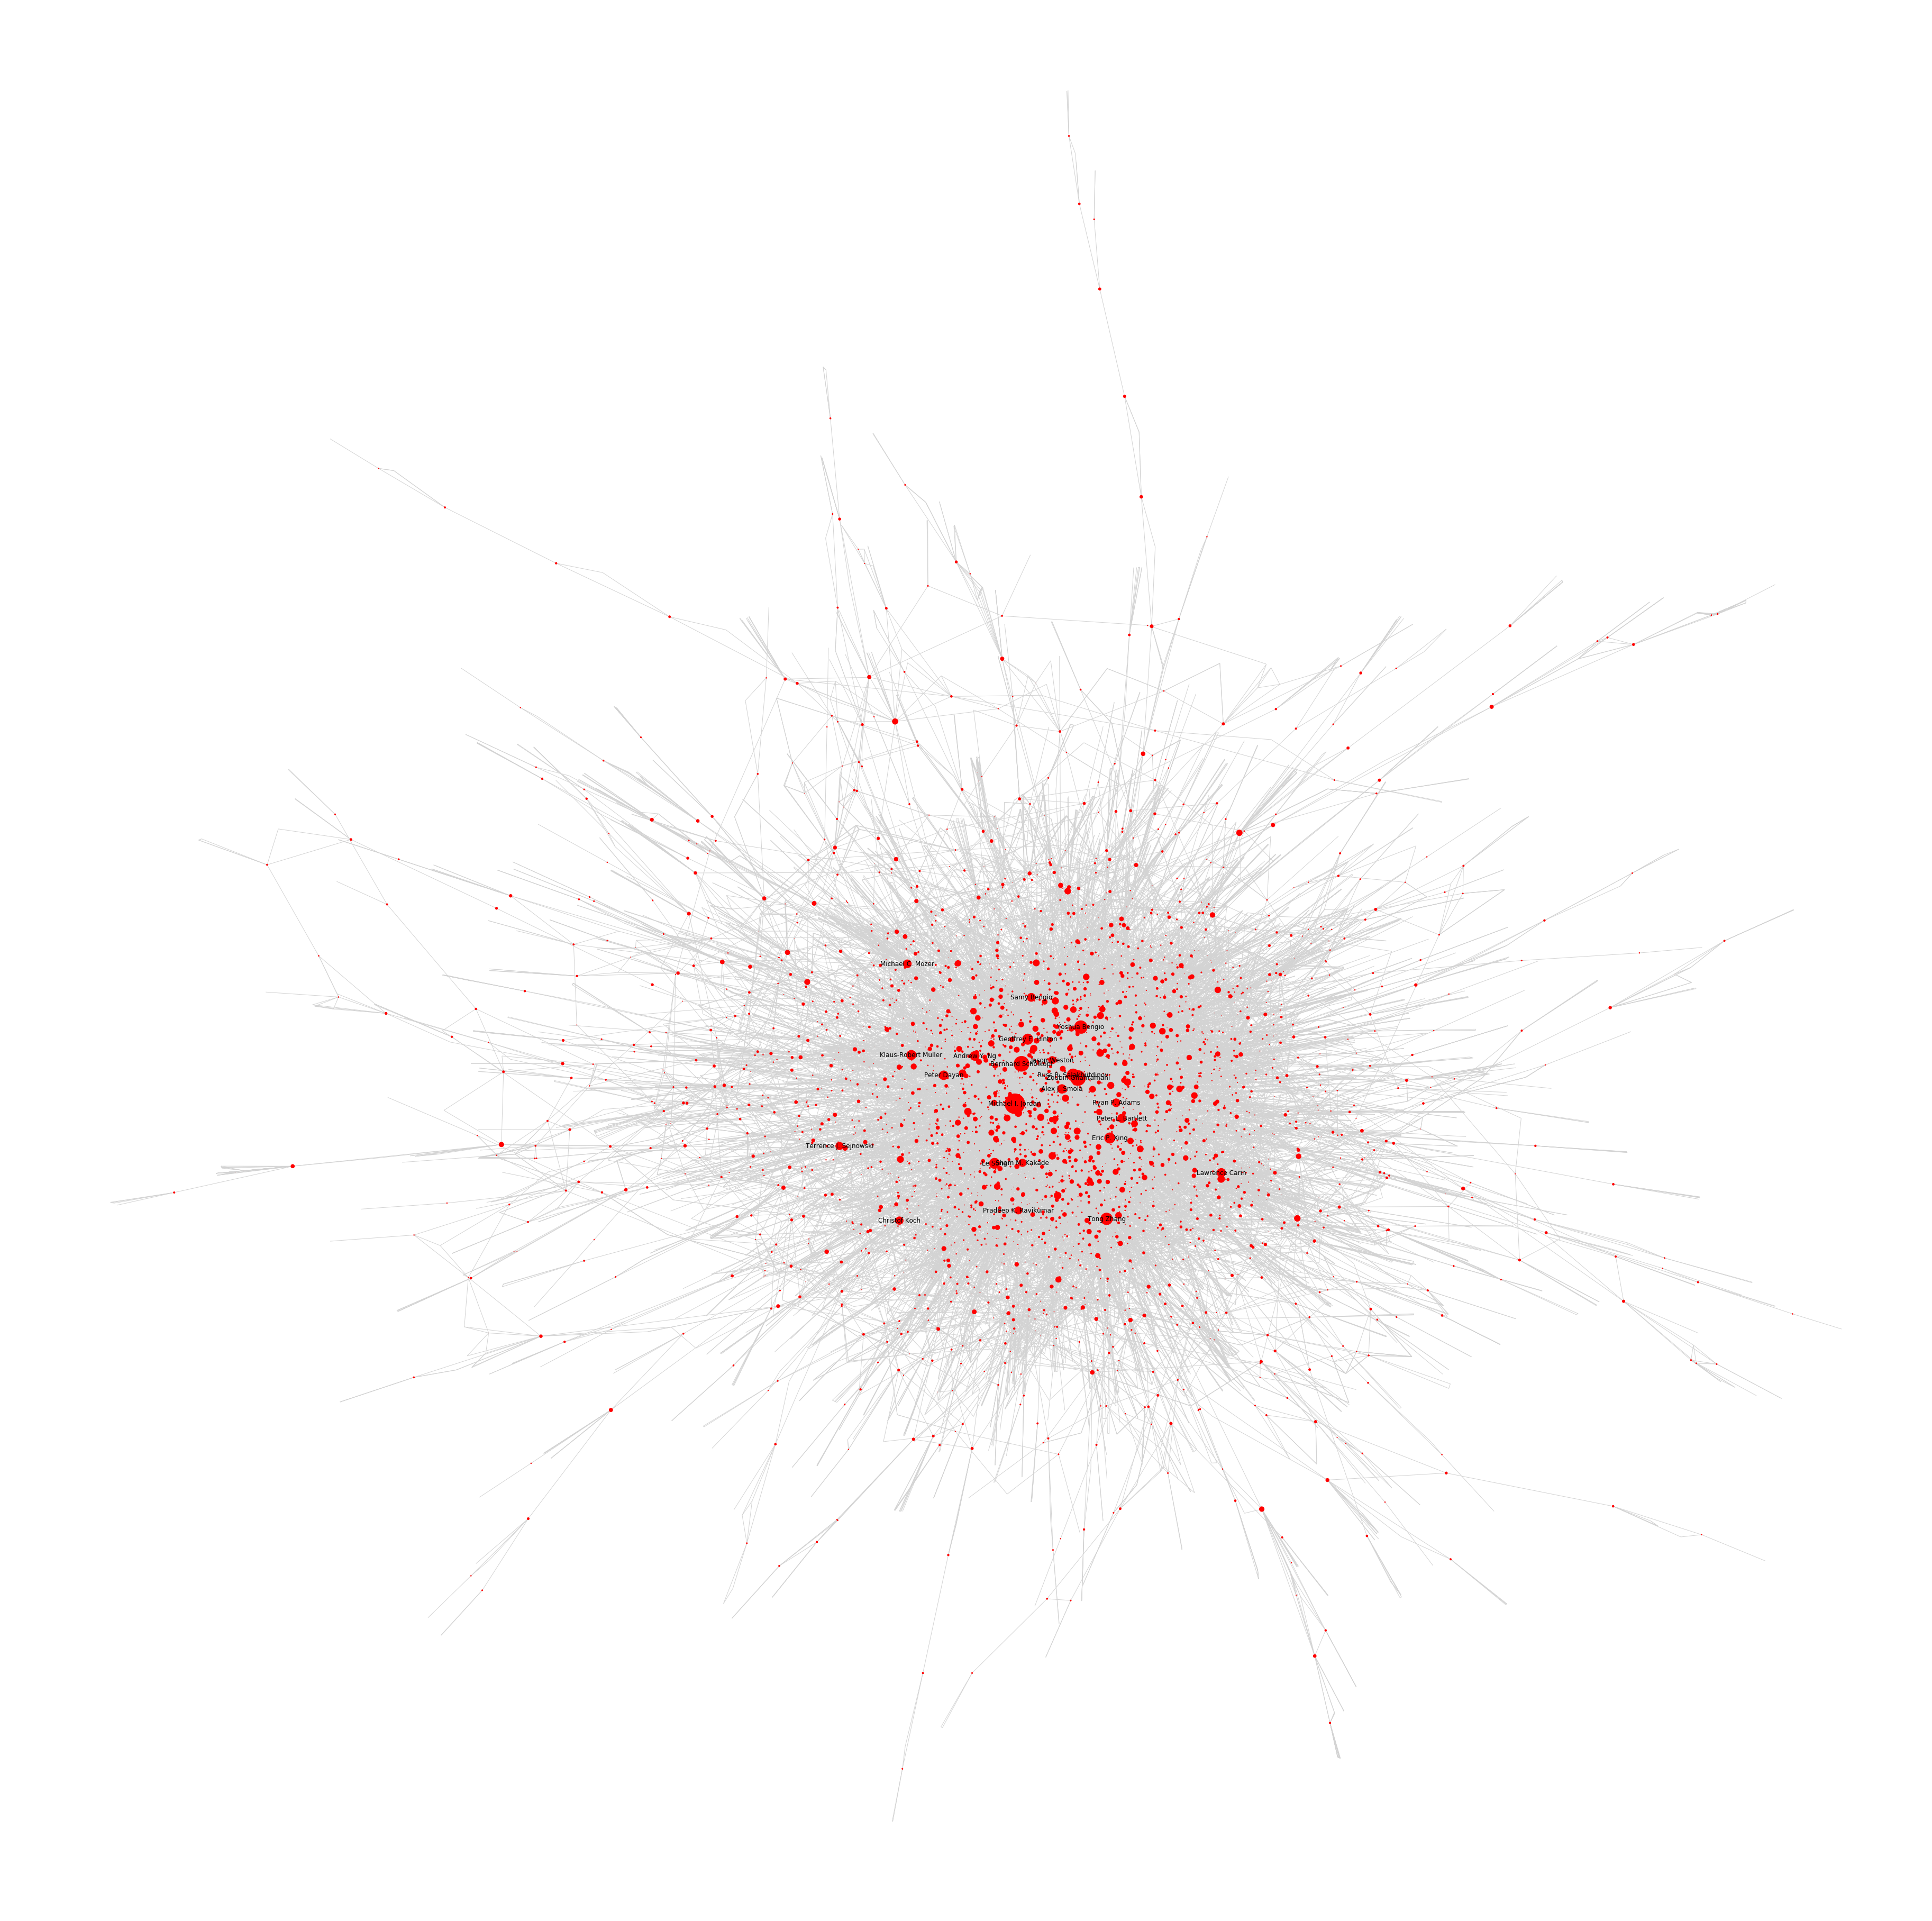

In [30]:
plt.figure(figsize=(50, 50))
nx.draw(graph.subgraph(largest_cc), node_size=node_size, edge_color='lightgray', labels=lables)

In [31]:
nx.average_shortest_path_length(graph.subgraph(largest_cc))

5.951291924390921

**Clustering coefficient**  is a measure of the degree to which nodes in a graph tend to cluster together. Evidence suggests that in most real-world networks, and in particular social networks, nodes tend to create tightly knit groups characterised by a relatively high density of ties.  
Here we compute the average clustering coefficient for the co-author network and get 0.7, which means the authors tend to co-operate together.

In [32]:
nx.average_clustering(graph.subgraph(largest_cc))

0.7009289800022787

In [33]:
nx.density(graph.subgraph(largest_cc))

0.0006096121538091715

**Construct a more sparse co-author graph**  
We filter the graph with edge weight bigger than 1. This means if two authors cooperate twice, we retain the edge between them, otherwise, we remove the edge between them.

In [34]:
G = nx.Graph(((source, target, attr) for source, target, attr in graph.edges(data=True) if attr['weight'] > 1))
nx.set_node_attributes(G, nodes.name.to_dict(), name='author')
component = pd.Series([len(i) for i in list(nx.connected_components(G))]).value_counts().sort_index()
component = pd.DataFrame(component).reset_index()
component.columns = ['component_size', 'number of components']
component

component_size  number of components
0                2                   208
1                3                    86
2                4                    43
3                5                    19
4                6                    12
5                7                     5
6                8                     7
7                9                     4
8               10                     3
9               11                     2
10              13                     3
11              14                     1
12              16                     1
13              17                     1
14              19                     1
15              26                     1
16              32                     1
17              43                     1
18            1321                     1

**We highlight the nodes with betweenness centrality of the top 5%**

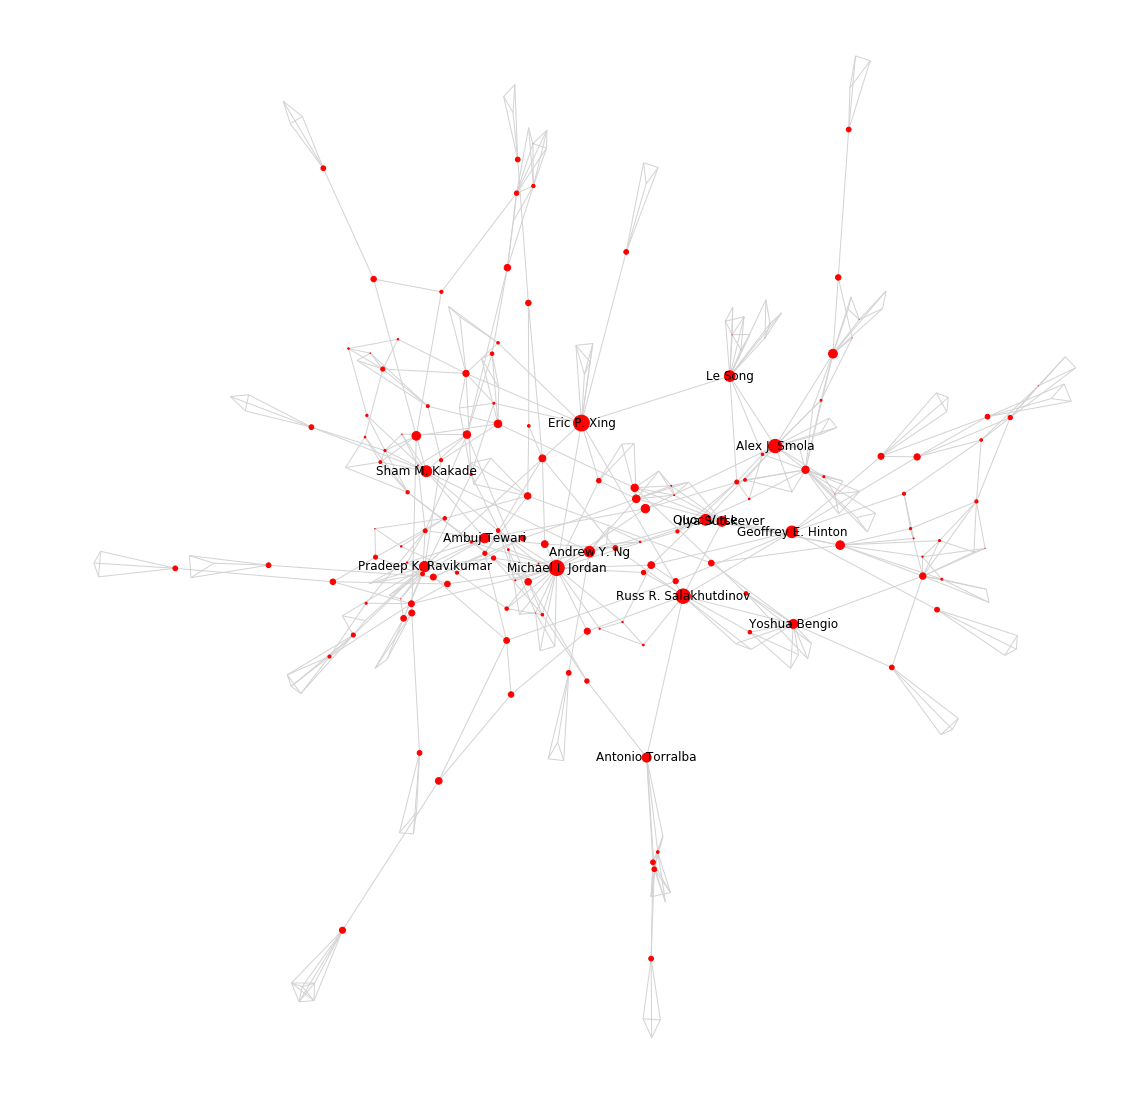

In [35]:
lc = max(nx.connected_components(G), key=len)
core = nx.k_core(G.subgraph(lc), k=3)
core = core.subgraph(max(nx.connected_components(core), key=len))
node_size = pd.Series(nx.betweenness_centrality(core))
labels = nx.get_node_attributes(core.subgraph(node_size[node_size.quantile(0.95) < node_size].index), 'author')
plt.figure(figsize=(15, 15))
pos= nx.layout.spring_layout(core)
nx.draw(core,pos=pos, edge_color='lightgray', node_size=node_size*1000, span=0.01, labels=labels, seed=2)
plt.savefig('figure/author_collab_large.pdf')